In [1]:
from importlib import reload
from rlxutils import subplots
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import os

import omegaconf
from loguru import logger
from omegaconf import DictConfig, OmegaConf
import hydra
from progressbar import progressbar as pbar

from earthtext.datamodules import chipmultilabel
True
from importlib import reload
reload(chipmultilabel)

<module 'earthtext.datamodules.chipmultilabel' from '/home/ubuntu/earth-text/src/earthtext/datamodules/chipmultilabel.py'>

# load osm encoder model

In [2]:
model_ckpt_fname = "/opt/data/models/osm_emcoder_2024-04-22_23:40.ckpt"
model_conf_fname = model_ckpt_fname[:-5] + ".yaml"

if not os.path.isfile(model_ckpt_fname) or not os.path.isfile(model_conf_fname):
    raise ValueError("cannot find model or conf")

In [3]:
conf = OmegaConf.load(model_conf_fname)
m = hydra.utils.instantiate(conf.model)
m.load_state_dict(torch.load(model_ckpt_fname))

<All keys matched successfully>

## setup dataloader

In [4]:
dl = hydra.utils.instantiate(conf.dataloader)

2024-04-24 12:06:33.007 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:1041 - checking chip files for train split
100% (60396 of 60396) |##################| Elapsed Time: 0:00:11 Time:  0:00:110001
2024-04-24 12:06:44.285 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:1045 - read train split with 60295 chip files (out of 60396)
2024-04-24 12:06:44.285 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:1050 - max cache size is -1
2024-04-24 12:06:44.976 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:1041 - checking chip files for val split
100% (12304 of 12304) |##################| Elapsed Time: 0:00:00 Time:  0:00:000000
2024-04-24 12:06:45.933 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:1045 - read val split with 12288 chip files (out of 12304)
2024-04-24 12:06:45.934 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:1050 - max cache size is -1
2024-04-

In [61]:
def get_top10_sim(vectorbase, query):
    ntargets = (vectorbase.T / np.linalg.norm(vectorbase,axis=1)).T
    nquery   = query / np.linalg.norm(query)
    sims = ntargets.dot(nquery)
    top10idxs = np.argsort(sims)[-10:]
    return top10idxs

def get_targets_and_predictions(dataloader):
    targets = []
    predictions = []
    inputs = []
    chip_ids = []
    for batch in pbar(dataloader):
        x = torch.cat([batch['osm_ohecount'], batch['osm_ohearea'], batch['osm_ohelength']], axis=1).type(torch.float)
        
        t = batch['embedding']
    
        o = m(x)
    
        for ti in t.detach().numpy():
            targets.append(ti)
    
        for oi in o.detach().numpy():
            predictions.append(oi)

        for xi in x.detach().numpy():
            inputs.append(xi)

        for ci in batch['chip_id']:
            chip_ids.append(ci)
        
    targets = np.r_[targets]
    predictions = np.r_[predictions]
    inputs = np.r_[inputs]
    return targets, predictions, inputs, chip_ids

In [63]:
# load all data from selected split

dl.disable_chip_loading()
dataloader = dl.test_dataloader()
dataloader.dataset.normalize_input = True
dataloader.dataset.get_chip_id = True
targets, predictions, inputs, chip_ids = get_targets_and_predictions(dataloader)


100% (420 of 420) |######################| Elapsed Time: 0:00:05 Time:  0:00:050000


In [64]:
from earthtext.datamodules.components import chipmultilabel

inputs = inputs * chipmultilabel.inputs_std + chipmultilabel.inputs_mean

In [49]:
retained_classes = np.r_[[0, 1, 2, 3, 4, 5, 6, 7, 8, 13, 14, 15, 18, 20, 23, 25, 30, 31, 33, 37, 38, 43, 58, 61, 63, 64, 68, 71, 77, 78, 87, 93, 95, 96, 98]]

from earthtext.osm import  multilabel 
retained_class_names = [multilabel.kvmerged.inverse_codes[i] for i in retained_classes]

In [16]:
n = inputs.shape[1]//3
counts, areas, lengths = inputs[:, :n][:, retained_classes],  inputs[:, n:2*n][:, retained_classes], inputs[:, 2*n:][:, retained_classes]
counts.shape, areas.shape, lengths.shape

((13411, 35), (13411, 35), (13411, 35))

Text(0.5, 1.0, 'lengths')

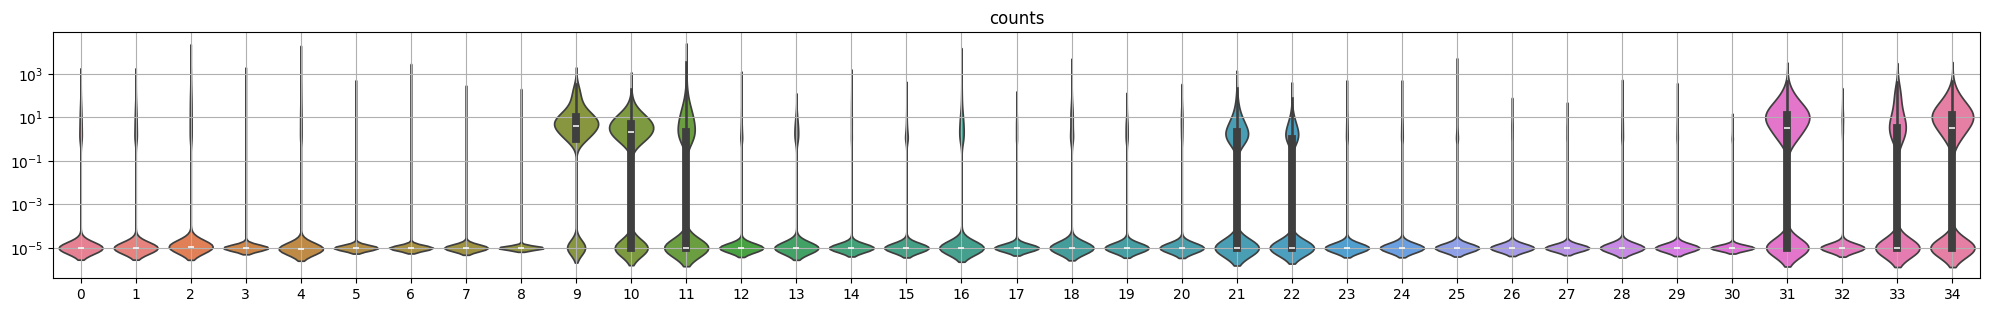

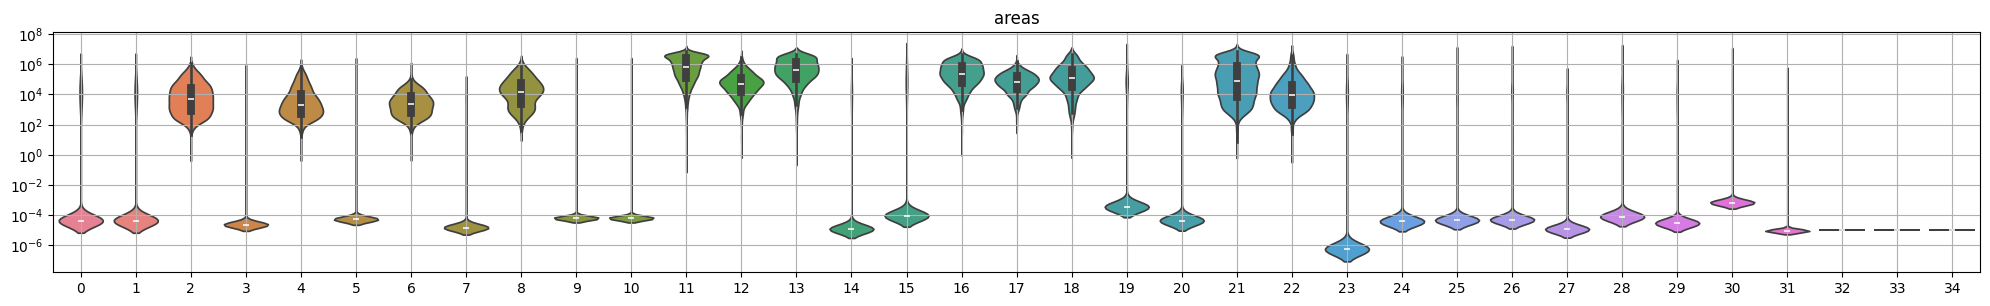

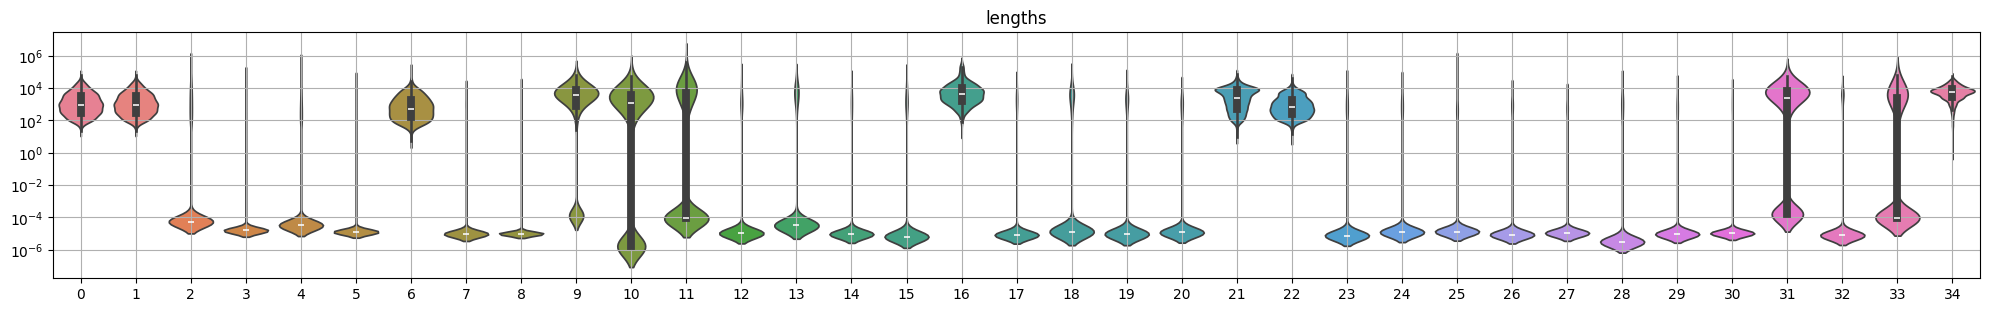

In [38]:
import seaborn as sns

log_scale = True
eps = 1e-5
for ax,i in subplots(1, usizex=20):
    sns.violinplot(pd.DataFrame(counts)+eps, log_scale=log_scale , ax=ax)
plt.grid()
plt.title("counts")

for ax,i in subplots(1, usizex=20):
    sns.violinplot(pd.DataFrame(areas)+eps, log_scale=log_scale , ax=ax)
plt.grid()
plt.title("areas")

for ax,i in subplots(1, usizex=20):
    sns.violinplot(pd.DataFrame(lengths)+eps, log_scale=log_scale , ax=ax)
plt.grid()
plt.title("lengths")

In [32]:
z = counts[:,0]
np.mean(z<1e-5), z.mean()

(0.8861382447244799, 1.46566248075689)

In [56]:
def show_histograms(x, title):
    for ax,i in subplots(x.shape[1], n_cols=7):
        z = x[:,i]
        a,b = np.percentile(z, [1,99])
        zz = z[ (z>0) & (z>b)]
        plt.hist(zz, bins=50);
        plt.grid()
        plt.title(f"{i}: {retained_class_names[i]}\n{title}, zeros pct {np.mean(z<1e-3):.3f}")

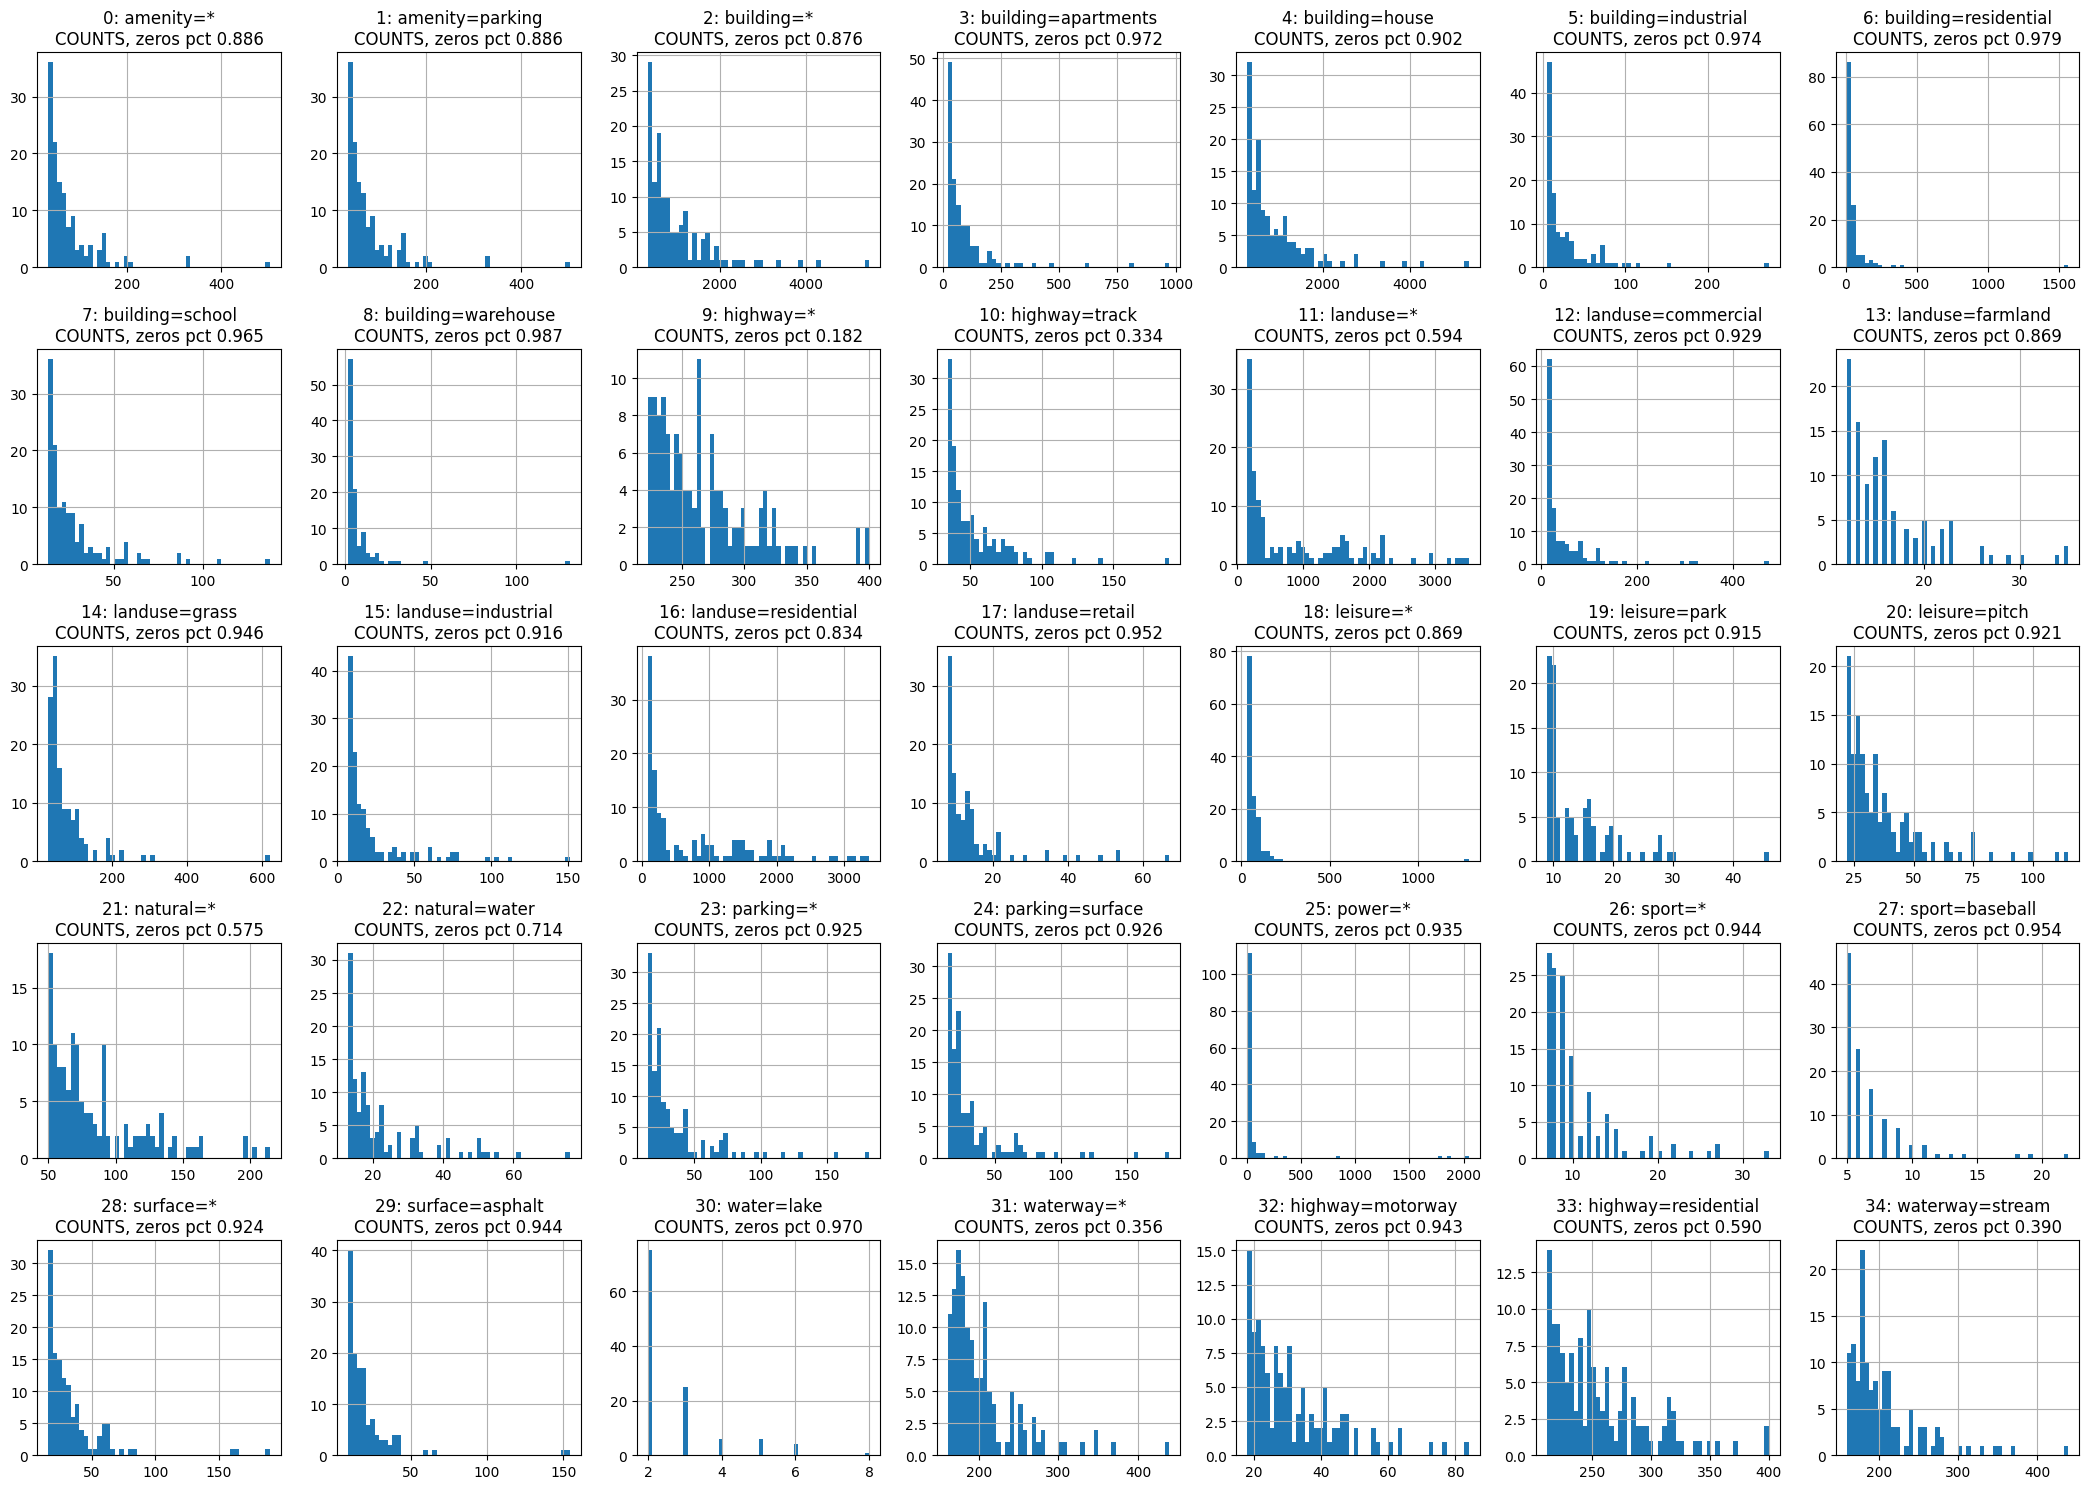

In [57]:
show_histograms(counts, 'COUNTS')

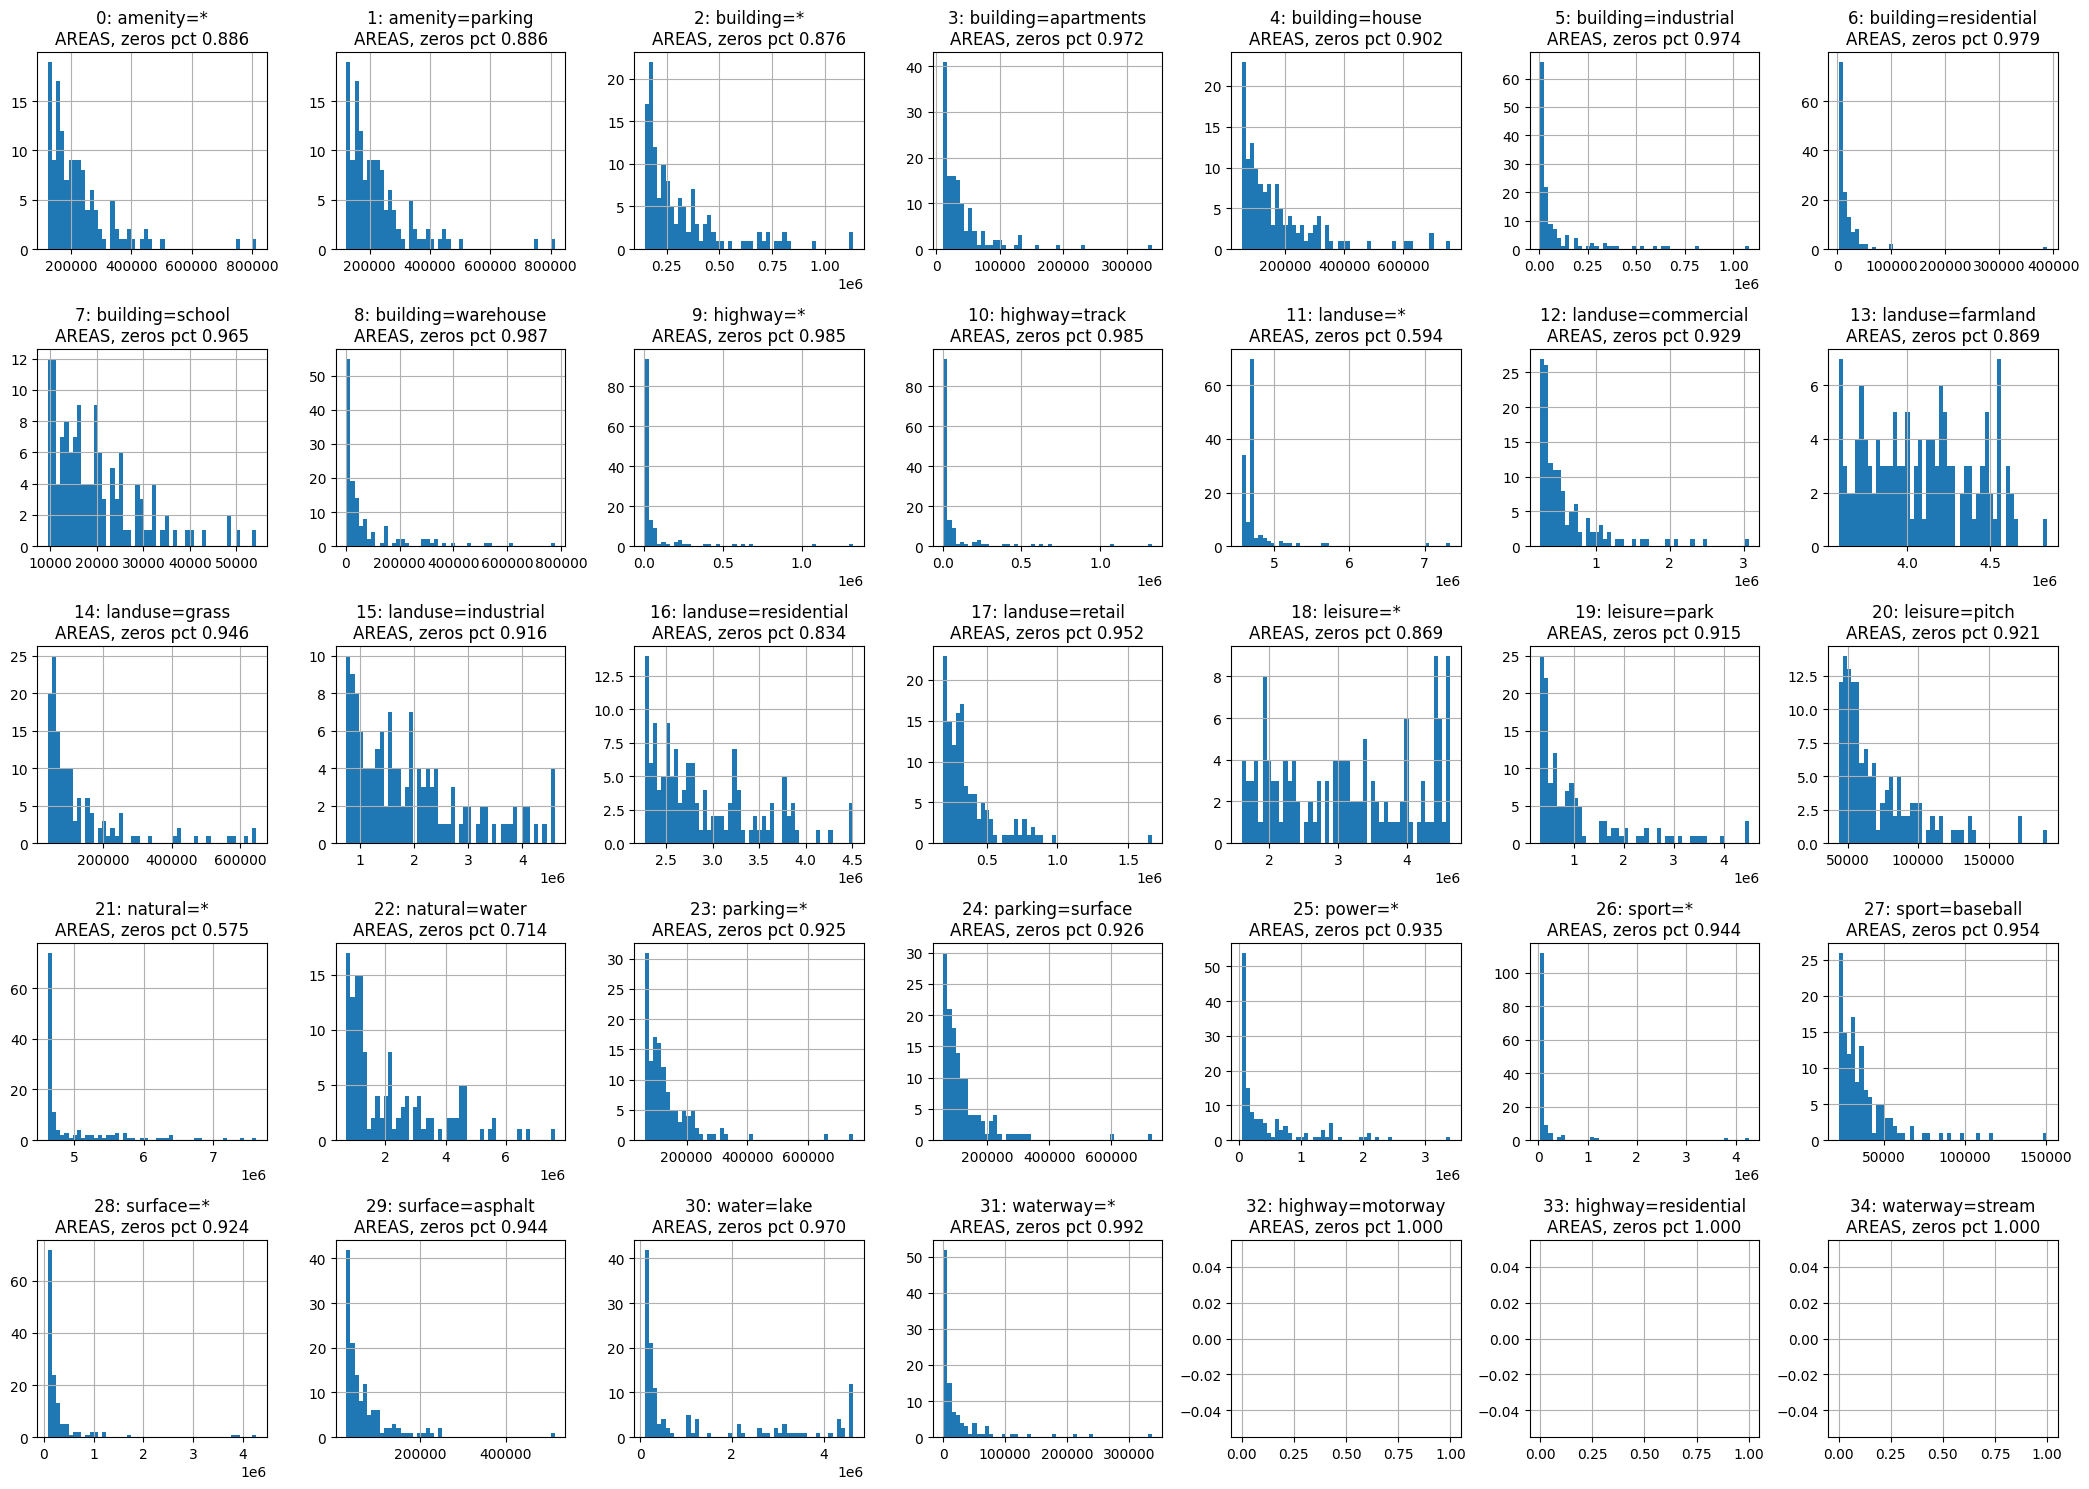

In [58]:
show_histograms(areas, 'AREAS')

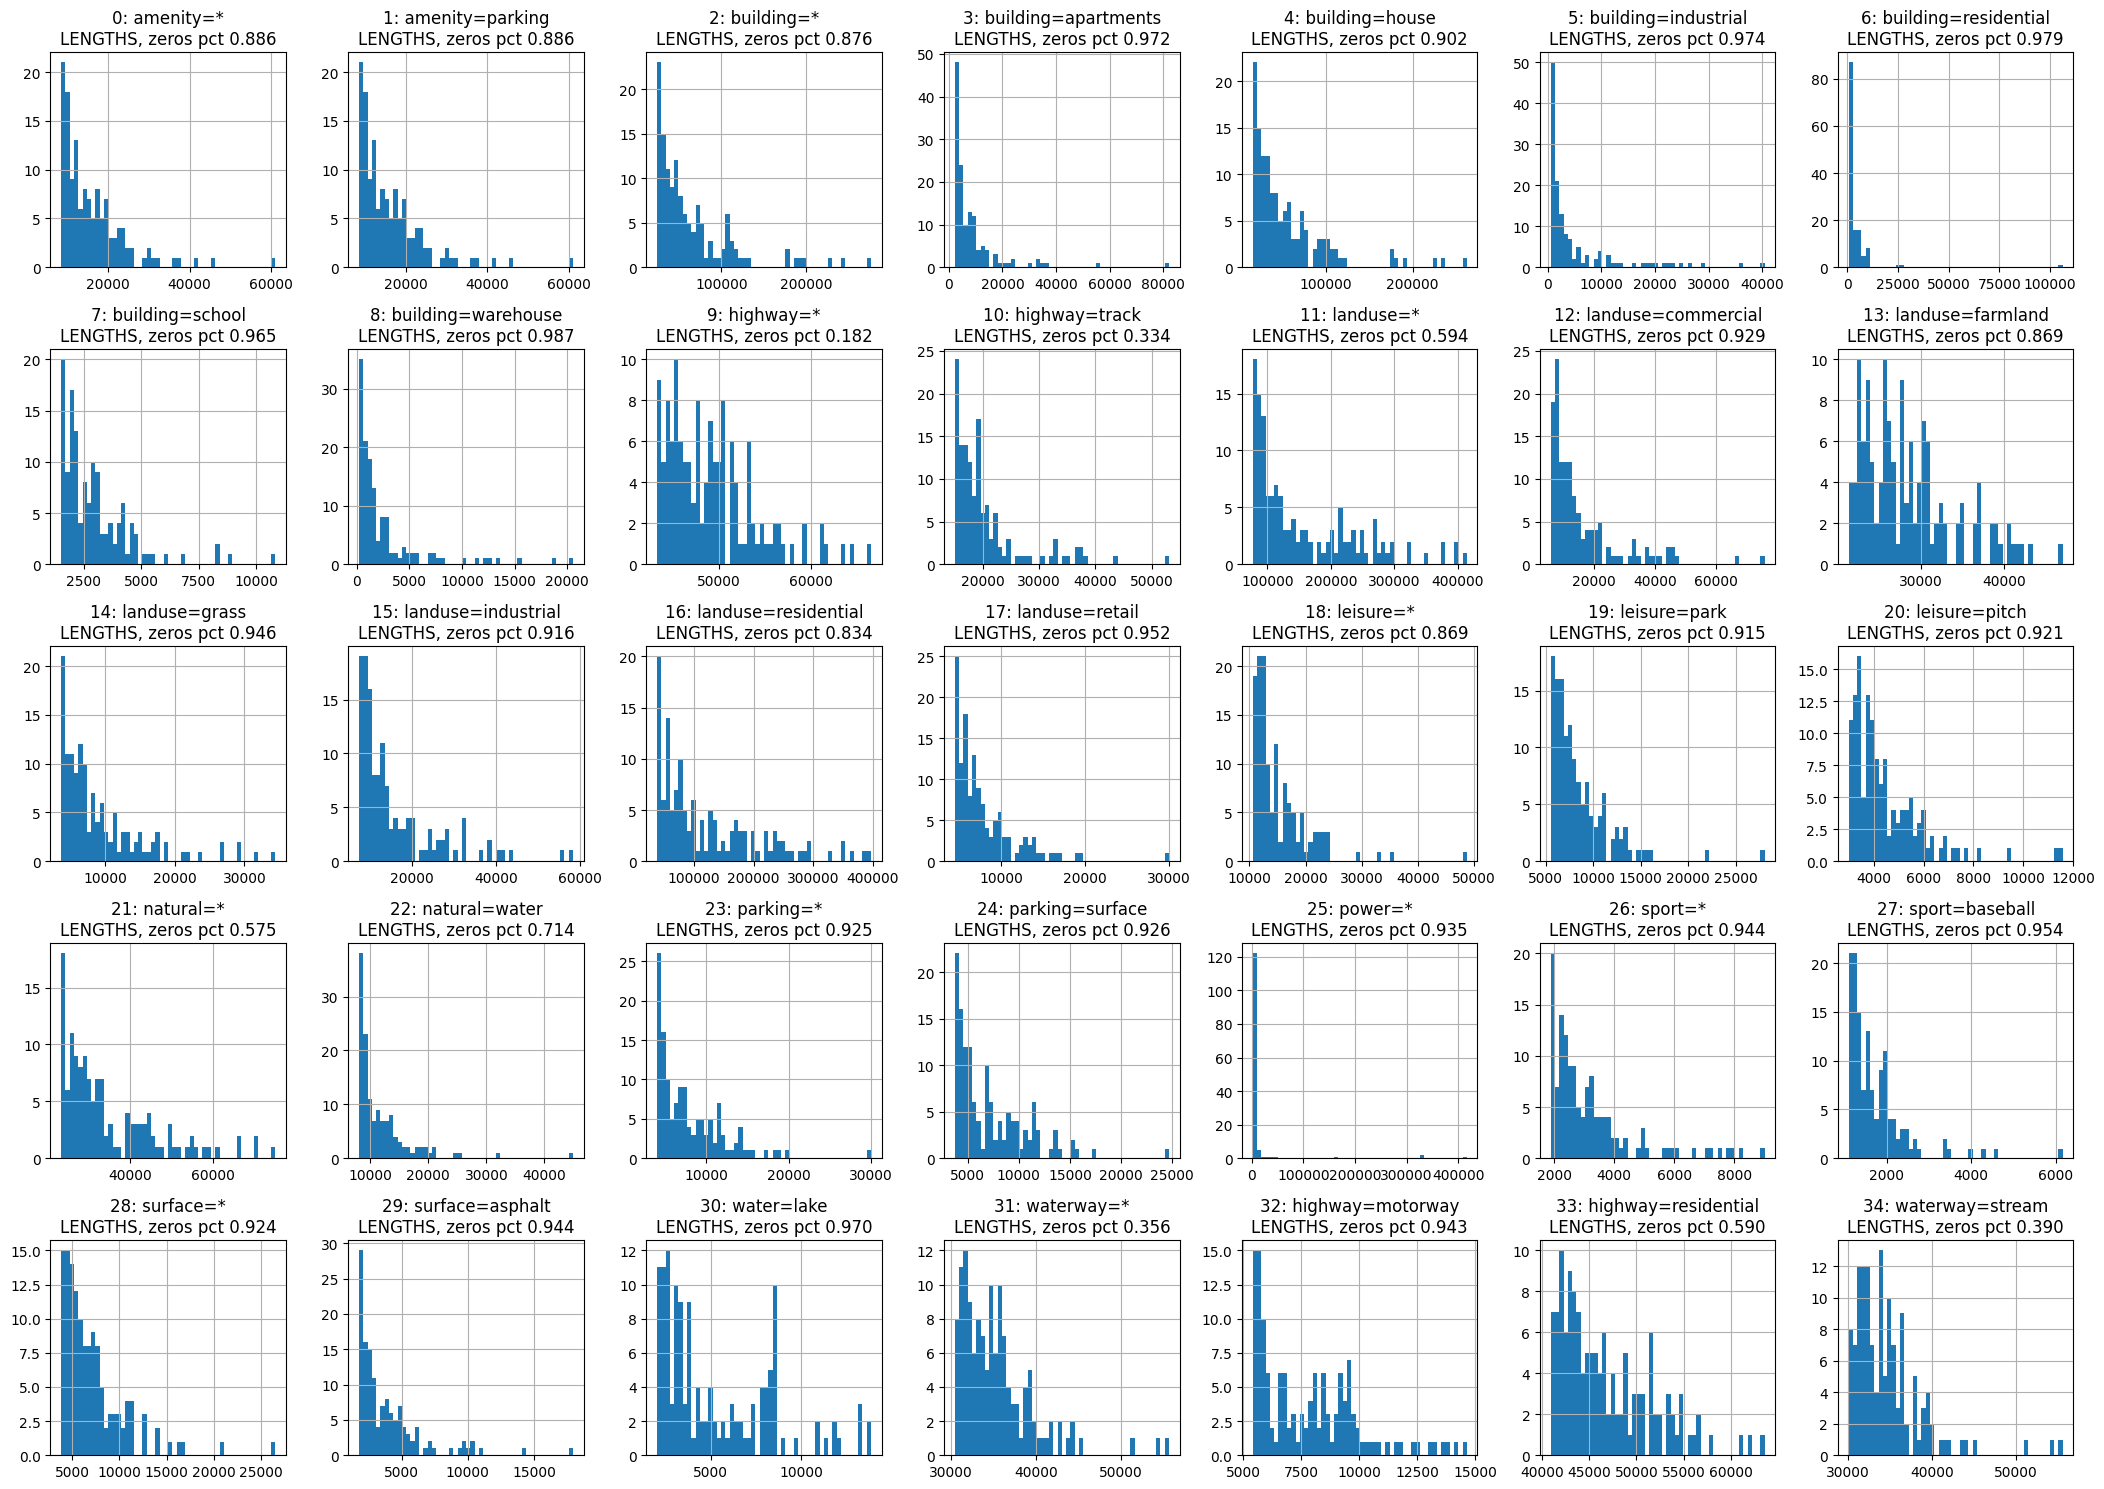

In [59]:
show_histograms(lengths, 'LENGTHS')

In [65]:
np.argmax(counts[:,25])

13401

In [67]:
chip_id = chip_ids[np.argmax(counts[:,25])]
chip_id

'183f7f3bf3cab'

In [72]:
chip_record = dataloader.dataset.metadata.loc[chip_id]
chip_record

onehot_count         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 1, ...
onehot_area          [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
onehot_length        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
string_labels        [highway=*, highway=track, landuse=*, landuse=...
col                                                              83968
row                                                              80640
geometry             POLYGON ((-117.98133333333334 35.2586666666666...
esawc_proportions    {'10': 0.0001220703125, '100': 0.0, '20': 0.19...
split                                                             test
Name: 183f7f3bf3cab, dtype: object

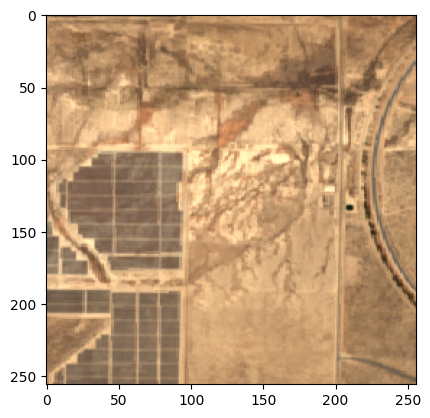

In [78]:
from earthtext.io import io
c = io.read_chip("/opt/data/clay-california-worldcover-rgbnir-vvvh-chips/chips/", chip_record.col, chip_record.row).numpy()[:3]
rgbimg = np.transpose(c, [1,2,0])
a,b = np.percentile(rgbimg, [5,99])
rgbimg = rgbimg *1.0 / b
rgbimg[rgbimg>1]=1
plt.imshow(rgbimg)


In [99]:
import geopandas as gpd
from pyproj import CRS
epsg4326 = CRS.from_epsg(4326)

osmobjs = pd.read_parquet(f"/opt/data/california-worldcover-chips/osm/{chip_id}.parquet")
osmobjs = osmobjs[osmobjs.area>0]

In [100]:
osmobjs

,tags,geometry,kind,length,area,stags,chip_id
147,{'power': 'plant'},b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x08\x00...,way,1457.498545,21365.842744,power: plant,183f7f3bf3cab
168,"{'description': 'ESTATE 2.5 ACRES, RESIDENTIAL...",b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x0c\x00...,way,1733.954935,47722.767296,"description: ESTATE 2.5 ACRES, RESIDENTIAL SUB...",183f7f3bf3cab
192,{'natural': 'water'},b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x11\x00...,way,113.709993,945.579621,natural: water,183f7f3bf3cab
217,{'natural': 'water'},b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x10\x00...,way,120.915386,1057.831050,natural: water,183f7f3bf3cab
354,"{'barrier': 'fence', 'power': 'plant', 'start_...",b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x0f\x00...,way,4732.764134,984202.819339,barrier: fence\n<br>\npower: plant\n<br>\nstar...,183f7f3bf3cab
...,...,...,...,...,...,...,...
8088,"{'generator:method': 'photovoltaic', 'generato...",b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00...,way,40.006638,48.612935,generator:method: photovoltaic\n<br>\ngenerato...,183f7f3bf3cab
8090,"{'generator:method': 'photovoltaic', 'generato...",b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00...,way,39.274005,47.575931,generator:method: photovoltaic\n<br>\ngenerato...,183f7f3bf3cab
8129,"{'generator:method': 'photovoltaic', 'generato...",b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00...,way,39.429411,47.795899,generator:method: photovoltaic\n<br>\ngenerato...,183f7f3bf3cab
8159,"{'generator:method': 'photovoltaic', 'generato...",b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00...,way,39.651421,48.110139,generator:method: photovoltaic\n<br>\ngenerato...,183f7f3bf3cab


In [106]:
r = []
for t in osmobjs.tags.values:
    for k,v in eval(t).items():
        if k=='power':
          r.append(f"{k}={v}")  

In [108]:
pd.Series(r).value_counts()

power=generator    2046
power=plant           2
Name: count, dtype: int64